In [1]:
from sage.config.config import DataArguments, TrainingArguments, MiscArguments

from sage.config import get_logger, logger_conf
from sage.data import get_dataloader
from sage.models import build_model
from sage.utils import seed_everything

In [2]:
data_args, training_args, misc_args = (
    DataArguments(),
    TrainingArguments(),
    MiscArguments(),
)
seed_everything(misc_args.seed)
misc_args.output_dir = "./"
data_args.batch_size = 1

logger_conf["handlers"]["file_handler"]["filename"] = misc_args.output_dir + "/run.log"
logger = get_logger(logger_conf)

test_dataloader = get_dataloader(data_args, misc_args, "test", logger)

2022-06-11 18:08:41,840 - root - INFO - Initialize dataset.
2022-06-11 18:08:41,881 - root - INFO - Successfully setup 146 brains for Test


In [ ]:
import torch
from sage.models import build_model

training_args.model_name = "resnet"
model = build_model(training_args, logger)
model = model.to("cpu")

path = "../failed_results/[20220517-0419]convnextlr0.0005warmup5%/ckpts/ep077.pt"
model.load_state_dict(torch.load(path))

from captum.attr import LayerGradCam, LayerAttribution

attributer = LayerGradCam(model, model.conv_layers()[0])

In [27]:
import pickle
from IPython.display import clear_output

import numpy as np

import torch.nn.functional as F
import nilearn
import nibabel
from nilearn import plotting
from nilearn.datasets import load_mni152_template, fetch_atlas_aal

from sage.utils.registration import Registrator

atlas = nilearn.image.load_img(fetch_atlas_aal().maps)
cut_coords = (0, 0, 0)
mni152 = load_mni152_template()

for idx, (brain, fname) in enumerate(
    zip(test_dataloader.dataset, test_dataloader.dataset.data_files)
):

    print(idx, fname)
    fname = f"{fname.split('.')[0]}.pkl"
    fnames = fname.split("/")
    fname = f"../pre-registered/{str(idx).zfill(3)}-{fnames[3]}"

    x = F.interpolate(brain[0][None, ...], size=mni152.get_fdata().shape)[0][0].numpy()
    x = nibabel.nifti1.Nifti1Image(x, affine=np.eye(4))
    registrator = Registrator()
    registrator(x, template=mni152.get_fdata())

    with open(fname, "wb") as f:
        pickle.dump(registrator.steps, f)

    attr = attributer.attribute(brain[0][None, ...])
    upsampled_attr = (
        LayerAttribution.interpolate(attr, (99, 117, 95), interpolate_mode="trilinear")
        .cpu()
        .detach()
    )

    transformed_xai = registrator.steps["SymmetricDiffeomorphicRegistration"].transform(
        upsampled_attr.numpy()[0][0]
    )
    transformed_xai_nifti = nibabel.nifti1.Nifti1Image(transformed_xai, mni152.affine)

    display = plotting.plot_img(
        transformed_xai_nifti, display_mode="mosaic", black_bg=True
    )
    display.add_overlay(atlas, cmap="black_green")
    display.savefig(f"../pre-registered/{str(idx).zfill(3)}-{fnames[3][:-3]}.png")
    clear_output()

0 /Users/daehyuncho/codespace/brainmask_mni/sub-OAS30341_ses-d0025_T1w.npy
Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]
[TranslationTransform3D] 1.1 sec:: LOSS -0.09452
Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]
[RigidTransform3D] 2.0 sec:: LOSS -0.09522
Optimizing level 2 [max iter: 2000]
Optimizing level 1 [max iter: 2000]
Optimizing level 0 [max iter: 200]
[AffineTransform3D] 53.5 sec:: LOSS -0.57719
[SymmetricDiffeomorphicRegistration] 28.4 sec
[optimize] 85.0 sec 


In [35]:
registered = registrator.steps["SymmetricDiffeomorphicRegistration"].transform(x.get_fdata())

In [32]:
from sage.xai.utils import _mni

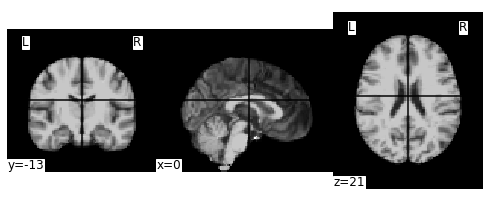

In [36]:
from sage.xai.utils import _mni
display = plotting.plot_img(load_mni152_template())
display.add_overlay(_mni(registered))